In [53]:
from tz.osemosys import Model
import matplotlib.pyplot as plt
import numpy as np

model = Model.from_yaml("../models/MDG/")
model.solve(solver="highs")

Writing integer variables.: 100%|██████████| 1/1 [00:00<00:00, 1477.39it/s]


Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
24013 rows, 19313 cols, 407630 nonzeros
22842 rows, 19174 cols, 386766 nonzeros
Presolve : Reductions: rows 22842(-20261); columns 19174(-12242); elements 386766(-201924)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     1.1437855744e+04 Pr: 520(4187.08) 0s
       7558     2.5304324859e+04 Pr: 0(0); Du: 0(4.55282e-10) 0s
       7558     2.5304324859e+04 Pr: 0(0); Du: 0(4.55282e-10) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 7558
Objective value     :  2.5304324859e+04
HiGHS run time      :          0.49
Writing the solution to /private/var/folders/5w/6cly89qs6hxfqs39wgpz_53h0000gn/T/linopy-solve-eexgji0b.sol


True

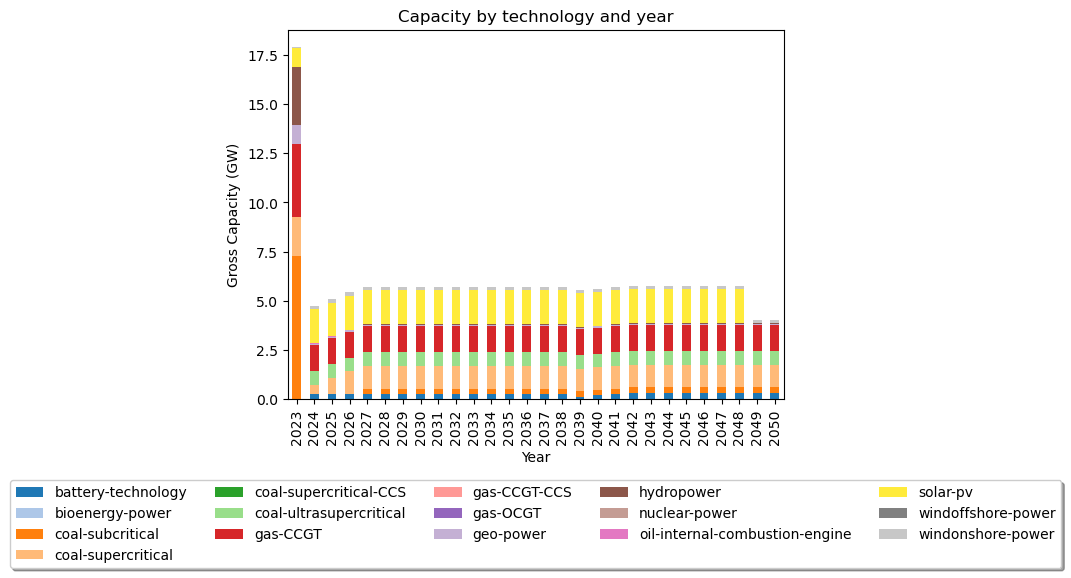

In [54]:
# Group the data by TECHNOLOGY and YEAR and calculate the sum of GrossCapacity
grouped_data = model.solution.GrossCapacity.to_dataframe().reset_index().groupby(by=["TECHNOLOGY", "YEAR"]).sum(numeric_only=True).reset_index()

# Exclude import, resource, production, and transmission results
grouped_data = grouped_data[~(grouped_data["TECHNOLOGY"].str.contains('|'.join(['step',
                                                                                'import',
                                                                                'resource',
                                                                                'production',
                                                                                'transmission',
                                                                                'liquefaction',
                                                                                'regasification'])))]

pivot_data = grouped_data.reset_index().pivot(index="YEAR", columns="TECHNOLOGY", values="GrossCapacity")

# Plot the data
color = ((0.12, 0.47, 0.71),
 (0.68, 0.78, 0.91),
 (1.0, 0.50, 0.05),
 (1.0, 0.73, 0.47),
 (0.17, 0.63, 0.17),
 (0.60, 0.87, 0.54),
 (0.84, 0.15, 0.16),
 (1.0, 0.60, 0.59),
 (0.58, 0.40, 0.74),
 (0.77, 0.69, 0.83),
 (0.55, 0.34, 0.29),
 (0.77, 0.61, 0.58),
 (0.89, 0.47, 0.76),
 (1.0, 0.92, 0.23), # solar = 'y'
 (0.50, 0.50, 0.50),
 (0.78, 0.78, 0.78),
 (0.74, 0.74, 0.13),
 (0.86, 0.86, 0.55),
 (0.09, 0.75, 0.81),
 (0.62, 0.85, 0.90))
pivot_data.plot(kind="bar", 
                stacked=True, 
                # color=plt.cm.tab20.colors)
                color = color)

# Set the labels and title
plt.xlabel("Year")
plt.ylabel("Gross Capacity (GW)")
plt.title("Capacity by technology and year")
plt.legend(loc='upper center', 
          bbox_to_anchor=(0.5, -0.2),
          fancybox=True, 
          shadow=True, ncol=5)

# Show the plot
plt.show()



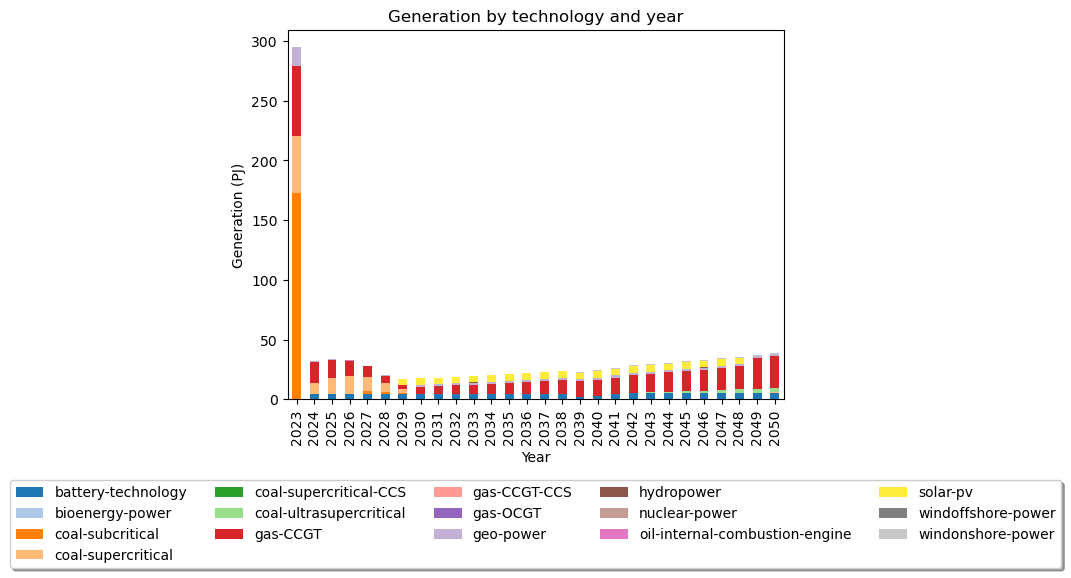

In [58]:
# Group the data by TECHNOLOGY and YEAR and calculate the sum of GrossCapacity
grouped_data = model.solution.ProductionByTechnology.to_dataframe().reset_index().groupby(by=["TECHNOLOGY", "YEAR"]).sum(numeric_only=True).reset_index()

# Exclude import, resource, production, and transmission results
grouped_data = grouped_data[~(grouped_data["TECHNOLOGY"].str.contains('|'.join(['step',
                                                                                'import',
                                                                                'resource',
                                                                                'production',
                                                                                'transmission',
                                                                                'liquefaction',
                                                                                'regasification'])))]

pivot_data = grouped_data.reset_index().pivot(index="YEAR", columns="TECHNOLOGY", values="ProductionByTechnology")

# Plot the data
pivot_data.plot(kind="bar", 
                stacked=True, 
                # color=plt.cm.tab20.colors)
                color = color)

# Set the labels and title
plt.xlabel("Year")
plt.ylabel("Generation (PJ)")
plt.title("Generation by technology and year")
plt.legend(loc='upper center', 
          bbox_to_anchor=(0.5, -0.2),
          fancybox=True, 
          shadow=True, ncol=5)

# Show the plot
plt.show()



In [63]:
DiscountRate = 0.05
# DiscountFactor = (1 + DiscountRate) ** (data_output.CapitalInvestment.YEAR - min(data_output.CapitalInvestment.YEAR))
DiscountFactorMid = (1 + DiscountRate) ** (model.solution.CapitalInvestment.YEAR - min(model.solution.CapitalInvestment.YEAR) + 0.5)

# all costs below are in discounted numbers
capital_cost = model.solution.DiscountedCapitalInvestment.to_dataframe().reset_index().groupby(by=["TECHNOLOGY", "YEAR"]).sum(numeric_only=True).reset_index()
capital_cost["idx_year"] = np.nan
capital_cost.loc[capital_cost.YEAR <= 2025,"idx_year"] = 1
capital_cost.loc[(capital_cost.YEAR >= 2026) & (capital_cost.YEAR <= 2030),"idx_year"] = 2
capital_cost.loc[(capital_cost.YEAR >= 2031) & (capital_cost.YEAR <= 2035),"idx_year"] = 3
capital_cost.loc[(capital_cost.YEAR >= 2036) & (capital_cost.YEAR <= 2040),"idx_year"] = 4
capital_cost.loc[(capital_cost.YEAR >= 2041) & (capital_cost.YEAR <= 2045),"idx_year"] = 5
capital_cost.loc[capital_cost.YEAR >= 2046,"idx_year"] = 6

annual_FOM = model.solution.AnnualFixedOperatingCost.to_dataframe().reset_index().groupby(by=["TECHNOLOGY", "YEAR"]).sum(numeric_only=True).reset_index()
annual_FOM.AnnualFixedOperatingCost = annual_FOM.AnnualFixedOperatingCost / np.tile(DiscountFactorMid,61)

operating_cost = model.solution.OperatingCost.to_dataframe().reset_index().groupby(by=["TECHNOLOGY", "YEAR"]).sum(numeric_only=True).reset_index()
operating_cost.OperatingCost = operating_cost.OperatingCost / np.tile(DiscountFactorMid,61)
operating_cost["DiscountedFOM"] = annual_FOM.AnnualFixedOperatingCost / np.tile(DiscountFactorMid,61)
operating_cost["DiscountedVOM"] = operating_cost.OperatingCost - operating_cost.DiscountedFOM
operating_cost["idx_year"] = capital_cost["idx_year"]

sum_capital_cost = capital_cost.reset_index().groupby(by=["TECHNOLOGY","idx_year"]).sum(numeric_only=True).reset_index()
sum_capital_cost = sum_capital_cost[~(sum_capital_cost["TECHNOLOGY"].str.contains('|'.join(['step',
                                                                                'import',
                                                                                'resource',
                                                                                # 'production',
                                                                                'liquefaction',
                                                                                'regasification'])))].groupby(by="idx_year").sum(numeric_only=True).reset_index()

sum_operating_cost = operating_cost.reset_index().groupby(by=["TECHNOLOGY","idx_year"]).sum(numeric_only=True).reset_index()
sum_operating_cost = sum_operating_cost[~(sum_operating_cost["TECHNOLOGY"].str.contains('|'.join(['step',
                                                                                'import',
                                                                                'resource',
                                                                                # 'production',
                                                                                'liquefaction',
                                                                                'regasification'])))].groupby(by="idx_year").sum(numeric_only=True).reset_index()

data = sum_operating_cost
data["DiscountedCapitalInvestment"] = sum_capital_cost.DiscountedCapitalInvestment

# Plot the data
data.plot(x = "YEAR", y = ["DiscountedCapitalInvestment","DiscountedFOM","DiscountedVOM"], kind="bar", 
                stacked=True, 
                color=plt.cm.tab20.colors)

# Set the labels and title
plt.xlabel("")
plt.ylabel("Total cost (M$)")
plt.title("Total cost from GENERATION technology")
plt.xticks([0,1,2,3,4,5], ['2023-2025','2026-2030','2031-2035','2036-2040','2041-2045','2046-2050'], rotation=30)
plt.legend(loc='upper center', 
          bbox_to_anchor=(0.5, -0.2),
          fancybox=True, 
          shadow=True, ncol=5)

# Show the plot
plt.show()

NameError: name 'np' is not defined

In [55]:
model.solution

<xarray.Dataset> Size: 3MB
Dimensions:                              (REGION: 1, YEAR: 28, TECHNOLOGY: 49,
                                          EMISSION: 4, STORAGE: 1, _REGION: 1,
                                          FUEL: 16, TIMESLICE: 12,
                                          MODE_OF_OPERATION: 6)
Coordinates:
  * REGION                               (REGION) <U3 12B 'MDG'
  * YEAR                                 (YEAR) int64 224B 2023 2024 ... 2050
  * TECHNOLOGY                           (TECHNOLOGY) <U56 11kB 'coal-hard-do...
  * EMISSION                             (EMISSION) <U6 96B 'CO2' ... 'SOx'
  * STORAGE                              (STORAGE) <U15 60B 'battery-storage'
  * _REGION                              (_REGION) <U3 12B 'MDG'
  * FUEL                                 (FUEL) <U21 1kB 'coal-brown' ... 'se...
  * TIMESLICE                            (TIMESLICE) <U5 240B 's1-h1' ... 's2...
  * MODE_OF_OPERATION                    (MODE_OF_OPERATION) <U7 168B 'GEN_B'...
Data variables: (12/44)
    AnnualFixedOperatingCost             (REGION, TECHNOLOGY, YEAR) float64 11kB ...
    AnnualTechnologyEmission             (REGION, TECHNOLOGY, YEAR, EMISSION) float64 44kB ...
    AnnualVariableOperatingCost          (YEAR, REGION, TECHNOLOGY) float64 11kB ...
    CapitalInvestment                    (REGION, TECHNOLOGY, YEAR) float64 11kB ...
    CapitalInvestmentStorage             (REGION, YEAR, STORAGE) float64 224B ...
    CapitalInvestmentTrade               (REGION, YEAR, FUEL, _REGION) float64 4kB ...
    ...                                   ...
    TotalTechnologyModelPeriodActivity   (REGION, TECHNOLOGY) float64 392B 0....
    Use                                  (REGION, YEAR, FUEL, TIMESLICE) float64 43kB ...
    marginal_cost_of_demand              (REGION, YEAR, FUEL, TIMESLICE) float64 43kB ...
    marginal_cost_of_demand_annual       (REGION, YEAR, FUEL) float64 4kB 1.7...
    marginal_cost_of_emissions_annual    (REGION, YEAR, EMISSION) float64 896B ...
    marginal_cost_of_emissions_total     (REGION, EMISSION) float64 32B nan ....

In [56]:
( model
 ._m
 .solution
 .RateOfActivity
 .to_dataframe()
 .reset_index()
 .query(" MODE_OF_OPERATION.isin(['CHARGE', 'DISCHARGE'])")
 .query(" TECHNOLOGY == 'battery' ")
 .groupby(by='MODE_OF_OPERATION')
 .sum(numeric_only=True)
)

,YEAR,RateOfActivity
MODE_OF_OPERATION,,


In [57]:
model._m.solution.TradeAnnual.to_dataframe().reset_index().query("FUEL == 'secondary-electricity' ").TradeAnnual.describe()

AttributeError: 'Dataset' object has no attribute 'TradeAnnual'

In [ ]:
model._m.solution

In [ ]:
from tz.osemosys import Model

# run model
iso_code = 'PAK'
model = Model.from_yaml(f"../models/{iso_code}/")
model.solve()

In [ ]:
model.solution.RateOfActivity.to_dataframe()

In [ ]:
for i in list( model.solution.variables ):
    if 'Emission' in i:
        print(i)

In [ ]:
# plot generation
gen = (
    model
    .solution
    .Production
    .to_dataframe()
    .reset_index()
    .pivot_table(
        index='YEAR', 
        columns='REGION', 
        values='Production',
        aggfunc='sum',
    )
)

gen.plot()